In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import re
import seaborn as sns
import string
import time
import tensorflow as tf
from tensorflow.keras import Input, layers, models, optimizers, losses
from keras.callbacks import EarlyStopping
import keras_tuner

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, ConfusionMatrixDisplay
from nltk.stem import WordNetLemmatizer as wnl
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')



2025-06-26 22:22:26.120366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750976546.422713      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750976546.509660      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Step 1: Problem Description
This Kaggle competition requires creating a machine learning model to predict if Tweets are about real disasters (target = 1) or not (target = 0).

### Data Description
The training dataset contains 7,613 Tweets that are labeled as either 0 (not relating to a distaster) or 1 (related to a disaster event).  There are five columns in the training dataset:
* id - a unique integer identifier
* keyword - a keyword from the Tweet
* location - location the from which the Tweet was sent
* text - the body of the Tweet
* target - the 0/1 label indicating if the Tweet is related to a disaster

The keyword and location columns may contain blank values.  The train.csv data will be used to create and validate the models.  The test.csv data will be used to submit to the Kaggle competition for scoring.

In [55]:
data_path = '/kaggle/input/nlp-getting-started'

df_labels = pd.read_csv(os.path.join(data_path, 'train.csv'))
df_submit = pd.read_csv(os.path.join(data_path, 'test.csv'))

df_labels.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


## Step 2: Exploratory Data Analysis (EDA)

### Data Distribution
There are more non-disaster Tweets than disaster Tweets in the dataset, but the imbalance is reasonable to move forward with modeling the dataset as-is.

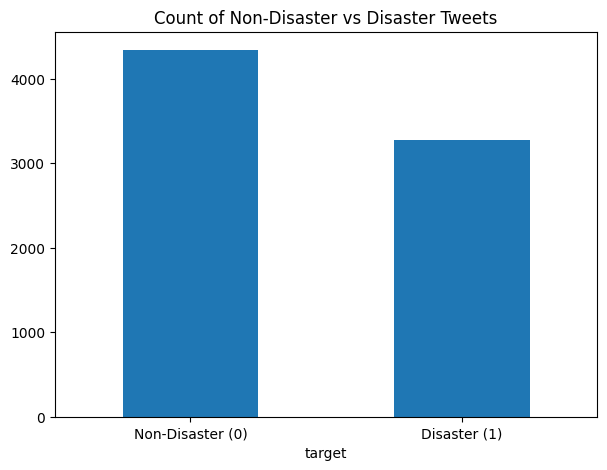

In [3]:
plt.figure(figsize=(7, 5))
ax = df_labels['target'].value_counts().plot(kind='bar', title='Count of Non-Disaster vs Disaster Tweets')
plt.xticks([0, 1], rotation=0, labels=['Non-Disaster (0)', 'Disaster (1)'])
plt.show()

### Tweet Length
The length of non-distaster and disaster Tweets seem to follow a Normal distribution and have a similar mean (14.7 words for non-disaster Tweets and 15.1 for disaster Tweets).  Non-disaster Tweets have a wider spread than disaster Tweets.  The longest Tweet is 31 words.

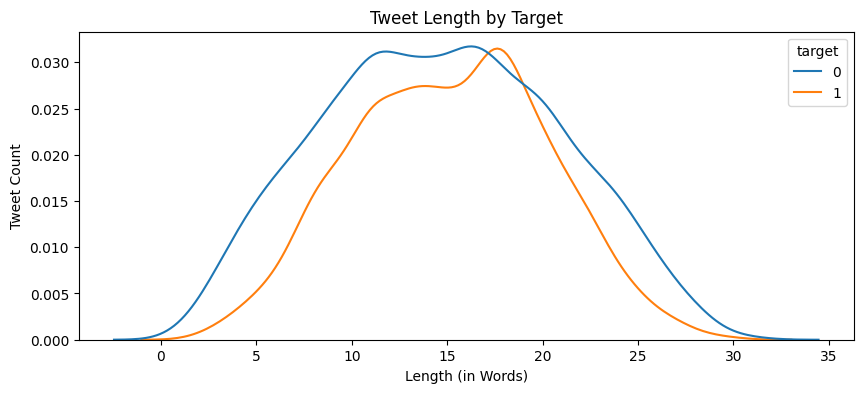

In [6]:
train_info = df_labels[['text', 'target']]
train_info['length'] = df_labels[['text', 'target']].text.apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 4))
sns.kdeplot(data = train_info, x='length', hue='target')
plt.title('Tweet Length by Target')
plt.xlabel('Length (in Words)')
plt.ylabel('Tweet Count');

In [5]:
train_info[['target', 'length']].groupby('target').describe()

length                                                  
         count       mean       std  min   25%   50%   75%   max
target                                                          
0       4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1       3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0

### Missing Values
There are a significant number of rows that are missing the location values.  There is no obvious way to impute missing values, so the best course of action is to ignore the location data.  I will remove the location column when cleaning the dataset.  There is a small percentage of rows missing the keyword column, but all of the missing rows are for non-disaster Tweets.  My hypothesis is that the keyword column will be duplicative information to the text column if the keyword column was derived from the text data, so I want to dig deeper into the keyword values.

In [18]:
missing_counts = df_labels.isnull().sum()/len(df_labels)
missing_counts

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

In [45]:
df_labels.isnull().groupby(['target']).sum()

,id,keyword,location,text
target,,,,
False,0,61,2533,0


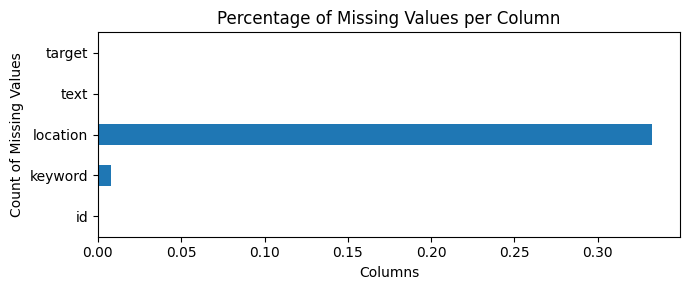

In [7]:
plt.figure(figsize=(7, 3))
missing_counts.plot(kind='barh')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Word Frequencies
Many of the top 20 words are "stop" words, so I'll clean the text data and then re-inspect the texts.


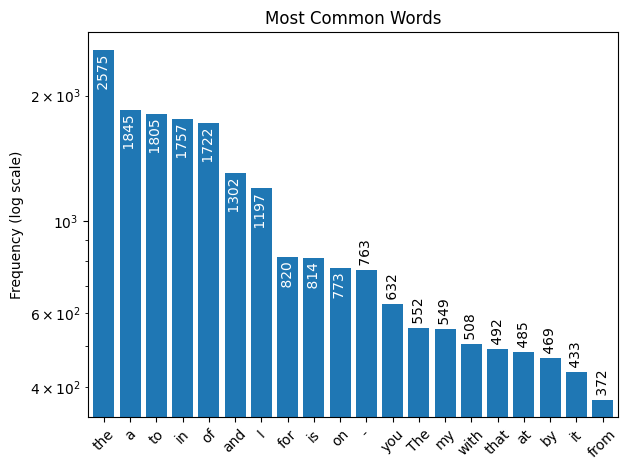

In [8]:
all_text = df_labels['text'].str.cat(sep=' ')
all_words = all_text.split()
word_counts = Counter(all_words).most_common(20)


y = [count for tag, count in word_counts]
x = [tag for tag, count in word_counts]

plt.bar(x, y)
plt.title('Most Common Words')
plt.ylabel('Frequency (log scale)')
plt.yscale('log') 
plt.xticks(rotation=45)
for i, (tag, count) in enumerate(word_counts):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

### Data Cleaning
I want to re-examine the text and keyword columns after cleaning the Tweets.  The Tweets (text) will be cleaned by:
* changing to lower case
* removing URLs
* removing numbers
* removing mentions
* removing HTML encoded strings
* removing special characters
* tokenizing
* removing stop words
* removing punctuation
* lemmatizing
  

In [7]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)   #remove URLs 
    text = re.sub(r'\d+', '', text)       #remove numbers
    text = re.sub(r'@\w+', '', text)      #remove mentions
    text = re.sub(r'&\w+;', '', text)     #remove HTML encoded strings, e.g., &amp;
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)      # remove punctuation/special chars
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopwords.words('english') and word not in string.punctuation]
    lemmatized_tokens = [wnl().lemmatize(word) for word in tokens]
    return ' '.join(filtered_tokens)

In [56]:
df_labels['text'] = df_labels['text'].apply(clean_text)
df_labels.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified officer...,1
3,6,NaN,NaN,people receive wildfires evacuation orders cal...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires pou...,1


### Tweet Length
After cleaning the Tweet text, the spread of Tweet length for non-disaster Tweets is still larger than that of disaster Tweets.  However, the spread is more similar between the two groups (3.7 for non-disaster and 3.2 for disaster).  Additionally, non-disaster Tweets have a tendency to be shorter than disaster Tweets (8.3 words for non-disaster and 9.2 for disaster).

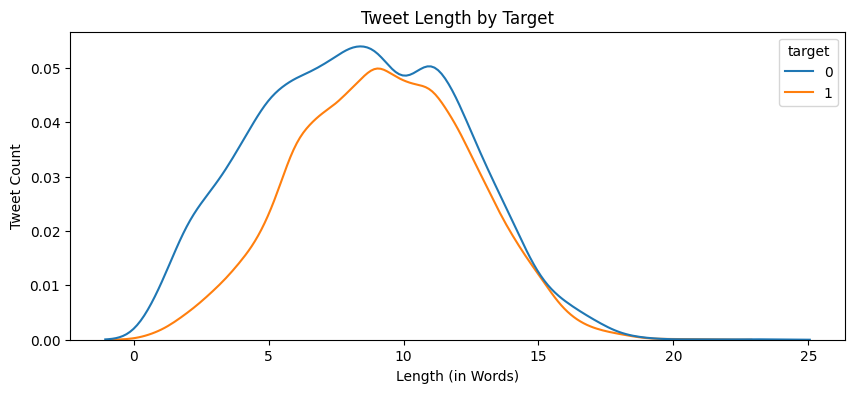

In [10]:
train_info = df_labels[['text', 'target']]
train_info['length'] = df_labels[['text', 'target']].text.apply(lambda x: len(x.split()))
train_info[['target', 'length']].groupby('target').describe()

plt.figure(figsize=(10, 4))
sns.kdeplot(data = train_info, x='length', hue='target')
plt.title('Tweet Length by Target')
plt.xlabel('Length (in Words)')
plt.ylabel('Tweet Count');

In [11]:
train_info[['target', 'length']].groupby('target').describe()

length                                               
         count      mean       std  min  25%  50%   75%   max
target                                                       
0       4342.0  8.338323  3.659928  1.0  6.0  8.0  11.0  23.0
1       3271.0  9.242434  3.175535  1.0  7.0  9.0  11.0  21.0

### Word Frequencies
I re-evaluated the most common words in the Tweets now that I've cleaned the data. which included removing "stop" words.  There are now some more meaningful words in the top 20, such as "emergency".  However, there are still some words, such as "like," that may not provide good predictive information.

I also created word clouds of the Tweet text and keywords.  There is some overlap, such as fire and evacuate.  Additionally, many of the keywords were directly found in the text so I am concluding that the keyword values were derived from the Tweet text. I am going to focus my model on the Tweet text.

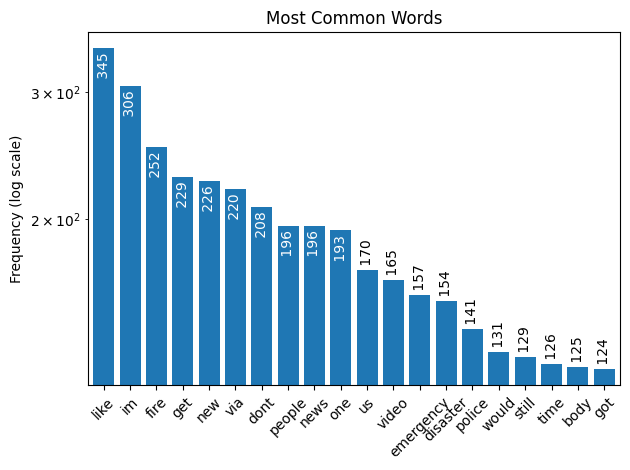

In [12]:
all_text = df_labels['text'].str.cat(sep=' ')
all_words = all_text.split()
word_counts = Counter(all_words)


y = [count for tag, count in word_counts.most_common(20)]
x = [tag for tag, count in word_counts.most_common(20)]

plt.bar(x, y)
plt.title('Most Common Words')
plt.ylabel('Frequency (log scale)')
plt.yscale('log') 
plt.xticks(rotation=45)
for i, (tag, count) in enumerate(word_counts.most_common(20)):
    plt.text(i, count, f' {count} ', rotation=90,
             ha='center', va='top' if i < 10 else 'bottom', color='white' if i < 10 else 'black')
plt.xlim(-0.6, len(x)-0.4) # optionally set tighter x lims
plt.tight_layout() # change the whitespace such that all labels fit nicely
plt.show()

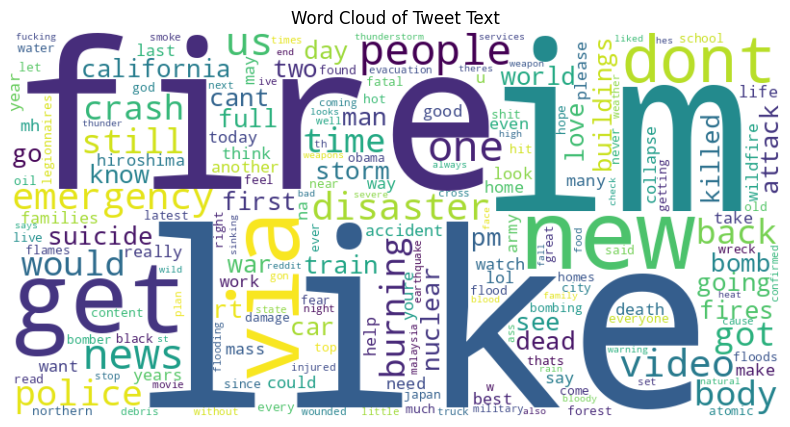

In [13]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Text')
plt.show()

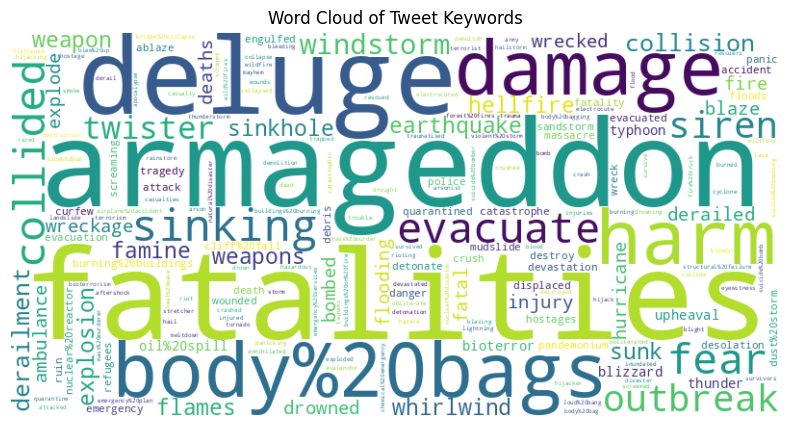

In [14]:
keywords = df_labels['keyword'].str.cat(sep=' ')
all_keywords = keywords.split()
keyword_counts = Counter(all_keywords)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(keyword_counts)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Tweet Keywords')
plt.show()

In [78]:
def keyword_search(row):
    if type(row['keyword']) == float:
        return False
    if row['keyword'] in row['text']:
        return True
    else:
        return False

df_labels['keyword_found'] = df_labels.apply(keyword_search, axis=1)
df_labels['keyword_found'].value_counts() 

keyword_found
True     5902
False    1711
Name: count, dtype: int64

### Remove Columns
As mentioned above, I want to focus my models on the potential predictive power of the Tweet texts, so I removed the location and keyword columns.

In [15]:
df_labels = df_labels[['id', 'text', 'target']]
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      7613 non-null   int64 
 1   text    7613 non-null   object
 2   target  7613 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 178.6+ KB


## Step 3:  Model Architecture

I split the training data provided by the Kaggle competition into an 80/20 split for train and test data.  I also set up a dictionary to capture model results for analysis.

In [16]:
df_train, df_test = train_test_split(df_labels, test_size=0.2)

In [17]:
model_results = {}

### Text Preprocessing
Processing and modeling the text requires a few steps that all occur within the TextVectorization layer.  

1. The data is tokenized (i.e., sentences are broken down into units/words).
2. The collectionn of all tokens is compiled into a vocabulary.
3. Each token is encoded to a unique integer value.
4. Text is mapped to a sequence of integer values using the encoding from the prior step.
5. The text is padded with trailing zeroes to create a rectangular matrix of encoded integers to feed into the machine learning model.

Using a couple example sentences, I can see that "I" and "have" are mapped to 2 and 3, respectively.  Additionally, the second sentence is padded with one trailing zero because it is one token/word shorter than the first sentence.  Note that the vocabulary includes an "[UNK]" value to represent any unknown tokens found in text that do not exist in the vocabulary.

In [18]:
example_data = ['I have three small dogs.', 'I have two cats.']
encoder_example = layers.TextVectorization()
encoder_example.adapt(example_data)

print('Vocabulary:')
print(encoder_example.get_vocabulary())
print('\nEncoded sequences:')
print(encoder_example(example_data).numpy())

Vocabulary:
['', '[UNK]', 'i', 'have', 'two', 'three', 'small', 'dogs', 'cats']

Encoded sequences:
[[2 3 5 6 7]
 [2 3 4 8 0]]


2025-06-26 22:36:17.509824: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


### Training Vocabulary and vocab size
When adapting the TextVectorization layer to the entire set of text values, I get a vocabulary of 12,673 tokens.  I opted to define a smaller maximum vocabulary size of 5,000 to improve model speed and focus on tokens that appear more often in the Tweets.

In [19]:
encoder = layers.TextVectorization()
encoder.adapt(df_train['text'].values)
len(encoder.get_vocabulary())

12673

In [20]:
VOCAB_SIZE = 5000
encoder = layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(df_train['text'].values)

The top 20 tokens in the vocabulary roughly match the most common words from the EDA above, so this is a good check that we are processing the text consistently.

In [21]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'like', 'im', 'via', 'fire', 'new', 'get', 'dont',
       'people', 'one', 'news', 'video', 'us', 'emergency', 'disaster',
       'police', 'would', 'time', 'got'], dtype='<U27')

### Encoder
As mentioned above, the TextVectorization layer encodes each token into a unique integer value and pads sentences/Tweets with trailing zeroes to create rectangular matrices.

In [22]:
encoder(df_train['text'].values)[:3].numpy()

array([[ 700, 2270, 1106, 2759, 2948,    5,   16, 1994,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1962,  545,  817,  118,  344,  401,   81, 1243,  402,  794, 1572,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   1,    1, 1454,    1,    1,  504, 1520,  365, 4168,    1,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0]])

### Early Stopping
I implemented early stopping to avoid unnecessary training time with the models.

In [23]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (e.g., validation loss)
    patience=5,          # Number of epochs to wait for improvement
    min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True, # Restore model weights from the epoch with the best value of the monitored quantity
    mode='min'           # Direction of the metric (e.g., 'min' for loss, 'max' for accuracy)
)

### Simple Recurrent Neural Network (RNN)
I started with a simple RNN to get an idea of how a low-complexity model would perform.

In [24]:
simple_rnn = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.SimpleRNN(32),
    layers.Dense(1) 
])

simple_rnn.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

simple_rnn_history = simple_rnn.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'Simple RNN', 
    elapsed_time,
    len(simple_rnn_history.epoch),
    max(simple_rnn_history.history['val_accuracy'])
)


Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5662 - loss: 3.9522 - val_accuracy: 0.5384 - val_loss: 0.9507
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5447 - loss: 0.8443 - val_accuracy: 0.5076 - val_loss: 0.7276
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5814 - loss: 0.7042 - val_accuracy: 0.5614 - val_loss: 0.6932
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6469 - loss: 0.6448 - val_accuracy: 0.6060 - val_loss: 0.6645
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6966 - loss: 0.5929 - val_accuracy: 0.6592 - val_loss: 0.6428
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7436 - loss: 0.5448 - val_accuracy: 0.7006 - val_loss: 0.6441
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8055 - loss: 0.4776 - val_accuracy: 0.7466 - val_loss: 0.7212
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8383 - loss: 0.4063 - val_accu

In [25]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747)}

#### Commentary
The simple RNN took about 24 seconds to train, ran for epochs, and achieved a validation accuracy of 0.778.  This is a decent start.

### Gated Recurrent Units (GRU)
RNNs can have difficulty with long-term relationships/dependencies in the dataset because the hidden state is being continually rewritten.  GRUs add some complexity onto the simple RNN.  Specifically, RNNs use reset and update gates to control the flow of information through the neural network.  Gates learn which inputs are important and store information in the memory unit to handle information in long sequences.  These gates help battle the "vanishing gradient" problem that can happen in backpropagation in RNNs.

In [26]:
rnn_gru = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.GRU(64),
    layers.Dense(64, activation='relu'),
    layers.Dense(1) 
])

rnn_gru.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

rnn_gru_history = rnn_gru.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'GRU RNN', 
    elapsed_time,
    len(rnn_gru_history.epoch),
    max(rnn_gru_history.history['val_accuracy'])
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - accuracy: 0.5784 - loss: 2.6344 - val_accuracy: 0.5811 - val_loss: 0.8772
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5705 - loss: 0.8223 - val_accuracy: 0.5811 - val_loss: 0.7071
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5721 - loss: 0.7014 - val_accuracy: 0.5811 - val_loss: 0.6977
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5649 - loss: 0.6965 - val_accuracy: 0.5811 - val_loss: 0.6925
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5676 - loss: 0.6844 - val_accuracy: 0.5811 - val_loss: 0.6854
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5737 - loss: 0.6765 - val_accuracy: 0.5844 - val_loss: 0.6750
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.5839 - loss: 0.6612 - val_accuracy: 0.7236 - val_loss: 0.6187
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8187 - loss: 0.5103 - val_accu

In [27]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747),
 1: ('GRU RNN', 45.350281715393066, 14, 0.7957977652549744)}

#### Commentary
The GRU nearly doubled training time and only slightly improved the validation accuracy from 0.778 to 0.7958.

### Bidirectional GRU
A bidirectional RNN may be helpful in this case by processing data both forward and backward (i.e., using past and future context) to make predictions.

In [28]:
rnn_gru_bidirection = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.Bidirectional(layers.GRU(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

rnn_gru_bidirection.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

rnn_gru_bidirection_history = rnn_gru_bidirection.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'GRU RNN - Bidirectional', 
    elapsed_time,
    len(rnn_gru_bidirection_history.epoch),
    max(rnn_gru_bidirection_history.history['val_accuracy'])
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - accuracy: 0.5741 - loss: 0.9383 - val_accuracy: 0.5804 - val_loss: 0.6881
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5946 - loss: 0.6683 - val_accuracy: 0.7269 - val_loss: 0.5886
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7846 - loss: 0.5026 - val_accuracy: 0.7564 - val_loss: 0.6006
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8501 - loss: 0.3724 - val_accuracy: 0.7978 - val_loss: 0.5052
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8729 - loss: 0.3379 - val_accuracy: 0.8030 - val_loss: 0.5400
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8920 - loss: 0.2795 - val_accuracy: 0.8050 - val_loss: 0.6637
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8893 - loss: 0.2817 - val_accuracy: 0.7846 - val_loss: 0.6419
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8851 - loss: 0.2868 - val_acc

In [29]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747),
 1: ('GRU RNN', 45.350281715393066, 14, 0.7957977652549744),
 2: ('GRU RNN - Bidirectional', 40.15496873855591, 9, 0.8049901723861694)}

#### Commentary
The bidirectional GRU converged more quickly than the prior GRU (9 epochs vs 14) while achieving a slightly higher validation accuracy of 0.805.

### Bidirectional Long Short Term Memory (LSTM)
LSTMs add complexity on top of GRUs by adding forget and output gates.  The forget gate controls what information is kept or forgotten from the previous state.  The output gate controls which parts of a cell are output to the next hidden state.

In [32]:
rnn_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

rnn_lstm.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])

start_time = time.time()

rnn_lstm_history = rnn_lstm.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'LSTM RNN - Bidirectional', 
    elapsed_time,
    len(rnn_lstm_history.epoch),
    max(rnn_lstm_history.history['val_accuracy'])
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.5725 - loss: 2.5347 - val_accuracy: 0.5811 - val_loss: 0.8027
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5734 - loss: 0.7525 - val_accuracy: 0.5502 - val_loss: 0.7176
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.5628 - loss: 0.7020 - val_accuracy: 0.5929 - val_loss: 0.6829
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.6046 - loss: 0.6614 - val_accuracy: 0.7045 - val_loss: 0.6014
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.7597 - loss: 0.5305 - val_accuracy: 0.7958 - val_loss: 0.5511
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8391 - loss: 0.4010 - val_accuracy: 0.7984 - val_loss: 0.5352
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8709 - loss: 0.3550 - val_accuracy: 0.8043 - val_loss: 0.5797
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.8731 - loss: 0.3329 - val_acc

In [36]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747),
 1: ('GRU RNN', 45.350281715393066, 14, 0.7957977652549744),
 2: ('GRU RNN - Bidirectional', 40.15496873855591, 9, 0.8049901723861694),
 3: ('LSTM RNN - Bidirectional', 39.57054615020752, 11, 0.8043335676193237)}

#### Commentary
The bidirectional LSTM performed similarly in training time and validation accuracy to the bidirectional GRU.

### Stacked LSTM with Dropout
As with CNNs, we can use dropout layers in RNNs to avoid overfitting the model to the training data.

In [37]:
stacked_lstm = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

stacked_lstm.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.0001),
              metrics=['accuracy'])


start_time = time.time()

stacked_lstm_history = stacked_lstm.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'Stacked LSTM RNN', 
    elapsed_time,
    len(stacked_lstm_history.epoch),
    max(stacked_lstm_history.history['val_accuracy'])
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.5628 - loss: 2.5709 - val_accuracy: 0.5811 - val_loss: 0.8710
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5547 - loss: 0.8453 - val_accuracy: 0.5811 - val_loss: 0.7206
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5383 - loss: 0.7414 - val_accuracy: 0.5752 - val_loss: 0.6893
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.5602 - loss: 0.7067 - val_accuracy: 0.5949 - val_loss: 0.6475
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.6416 - loss: 0.6300 - val_accuracy: 0.7341 - val_loss: 0.5267
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.7982 - loss: 0.4683 - val_accuracy: 0.7958 - val_loss: 0.5035
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.8444 - loss: 0.3846 - val_accuracy: 0.8004 - val_loss: 0.5871
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8671 - loss: 0.3564 - val_acc

In [38]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747),
 1: ('GRU RNN', 45.350281715393066, 14, 0.7957977652549744),
 2: ('GRU RNN - Bidirectional', 40.15496873855591, 9, 0.8049901723861694),
 3: ('LSTM RNN - Bidirectional', 39.57054615020752, 11, 0.8043335676193237),
 4: ('Stacked LSTM RNN', 68.44957065582275, 11, 0.8102429509162903)}

#### Commentary
Stacking multiple bidirectional layers and introducing the dropout layer increased both the training time and validation accuracy of the model.

### Hyperparameter Tuning
The Stacked LSTM RNN model had the highest validation accuracy, so let's see if tuning the hyperparameters can further improve the accuracy.  Specifically, I will look to tune the learning rate of the optimizer.  I plotted the model history using the learning rate of 0.0001 above against a new model with a learning rate of 0.01.  The higher learning rate had less smooth graphs and produced a larger difference between the training and validation accuracy.

In [39]:
def show_model_history(history):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.tight_layout()
    ax1.set_title('Loss')
    ax2.set_title('Accuracy')

    ax1.plot(history.epoch, history.history['loss'], label='Train')
    ax1.plot(history.epoch, history.history['val_loss'], label='Test')
    ax2.plot(history.epoch, history.history['accuracy'], label='Train')
    ax2.plot(history.epoch, history.history['val_accuracy'], label='Test')

    ax1.legend()
    ax2.legend()
    plt.show()

In [40]:
rnn_learning_rate = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), 
    encoder,
    layers.Embedding(VOCAB_SIZE, 64),
    layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

rnn_learning_rate.compile(loss=losses.BinaryCrossentropy(),
              optimizer=optimizers.Adam(0.01),
              metrics=['accuracy'])

start_time = time.time()

rnn_learning_history = rnn_learning_rate.fit(df_train['text'].values, 
                                    df_train['target'].values,
                                    epochs=20,
                                    validation_data=(df_test['text'].values, df_test['target'].values),
                                    callbacks=[early_stopping])

end_time = time.time()

elapsed_time = end_time - start_time

model_results[len(model_results)] = (
    'Stacked LSTM RNN - 0.01 Learning Rate', 
    elapsed_time,
    len(rnn_learning_history.epoch),
    max(rnn_learning_history.history['val_accuracy'])
)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 18s 31ms/step - accuracy: 0.6514 - loss: 1.0246 - val_accuracy: 0.7827 - val_loss: 0.6534
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.7840 - loss: 0.8182 - val_accuracy: 0.7374 - val_loss: 0.7005
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8076 - loss: 0.6345 - val_accuracy: 0.7682 - val_loss: 0.7299
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7902 - loss: 0.5602 - val_accuracy: 0.7216 - val_loss: 0.5698
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8509 - loss: 0.5048 - val_accuracy: 0.7899 - val_loss: 0.5856
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8913 - loss: 0.4650 - val_accuracy: 0.7722 - val_loss: 0.8029
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8657 - loss: 0.5132 - val_accuracy: 0.7722 - val_loss: 0.8866
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8918 - loss: 0.4735 - val_acc

In [41]:
model_results

{0: ('Simple RNN', 24.223429203033447, 10, 0.7780696153640747),
 1: ('GRU RNN', 45.350281715393066, 14, 0.7957977652549744),
 2: ('GRU RNN - Bidirectional', 40.15496873855591, 9, 0.8049901723861694),
 3: ('LSTM RNN - Bidirectional', 39.57054615020752, 11, 0.8043335676193237),
 4: ('Stacked LSTM RNN', 68.44957065582275, 11, 0.8102429509162903),
 5: ('Stacked LSTM RNN - 0.01 Learning Rate',
  58.99545431137085,
  9,
  0.7898883819580078)}

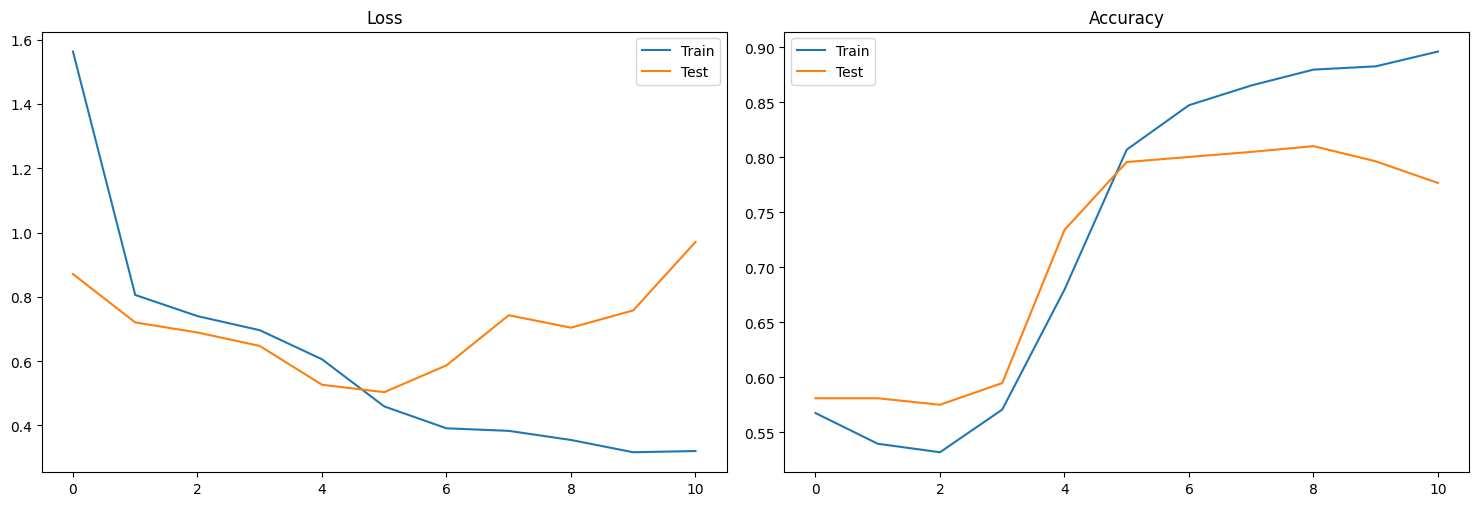

In [45]:
#0.0001 Learning Rate
show_model_history(stacked_lstm_history)

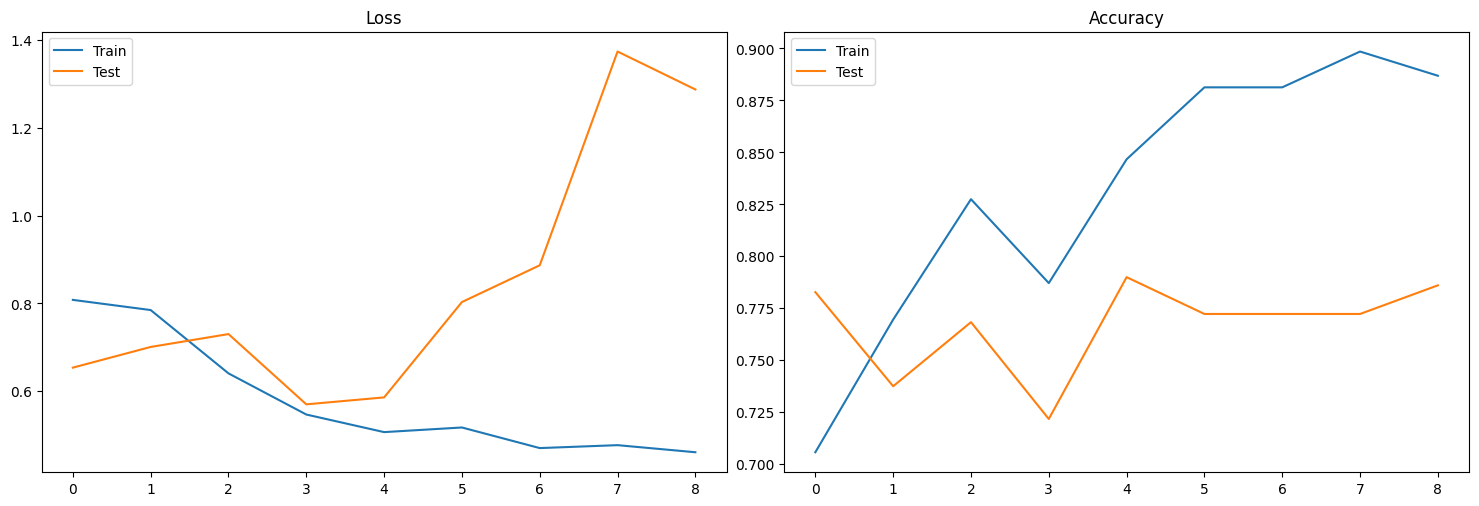

In [44]:
#0.01 Learning Rate
show_model_history(rnn_learning_history)

Now that I have a feel for the impact of the learning rate, I used the Keras Tuner to automate the hyperparameter tuning to find the best learning rate given the choices of 0.01, 0.005, 0.001, 0.0005, and 0.0001.

In [46]:
def build_model(hp):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(1,), dtype=tf.string), 
        encoder,
        layers.Embedding(VOCAB_SIZE, 64),
        layers.Bidirectional(layers.LSTM(64,  return_sequences=True)),
        layers.Bidirectional(layers.LSTM(32)),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1)
    ])

    learning_rates = hp.Choice('learning_rate', values=[0.01, 0.005, 0.001, 0.0005, 0.0001])
    model.compile(
        optimizer = optimizers.Adam(learning_rate=learning_rates),
        loss = 'binary_crossentropy',
        metrics = ['accuracy']
    )
    return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

In [47]:
tuner.search(
    df_train['text'].values, 
    df_train['target'].values,
    epochs=20,
    validation_data=(df_test['text'].values, df_test['target'].values),
    callbacks=[early_stopping]
)

Trial 5 Complete [00h 00m 48s]
val_loss: 0.586624026298523

Best val_loss So Far: 0.47883927822113037
Total elapsed time: 00h 04m 32s


#### Commentary
The Keras tuner found an optimal learning rate of 0.0001, which is the value I used in my original set of models.

In [48]:
tuner.get_best_hyperparameters()[0].get('learning_rate')

0.0001

## Step 4: Results and Analysis

The stacked LSTM RNN with dropout layer had the highest validation accuracy of 0.810.  However, it also had the longest training time due to the complexity and multiple layers of the model.  Interestingly, the models all converged in 9-11 epochs with the exception of the GRU that stopped early after 14 epochs.

The accuracy chart of the stacked LSTM RNN with dropout layer also shows a decline in validation accuracy after 8 epochs indicating that the model may be overfitting to the training data.

In [49]:
df = pd.DataFrame.from_dict(model_results, orient='index')
df.columns = ['Model', 'Training Time', 'Epochs', 'Max Validation Accuracy']
df.head()

,Model,Training Time,Epochs,Max Validation Accuracy
0,Simple RNN,24.223429,10,0.778070
1,GRU RNN,45.350282,14,0.795798
2,GRU RNN - Bidirectional,40.154969,9,0.804990
3,LSTM RNN - Bidirectional,39.570546,11,0.804334
4,Stacked LSTM RNN,68.449571,11,0.810243


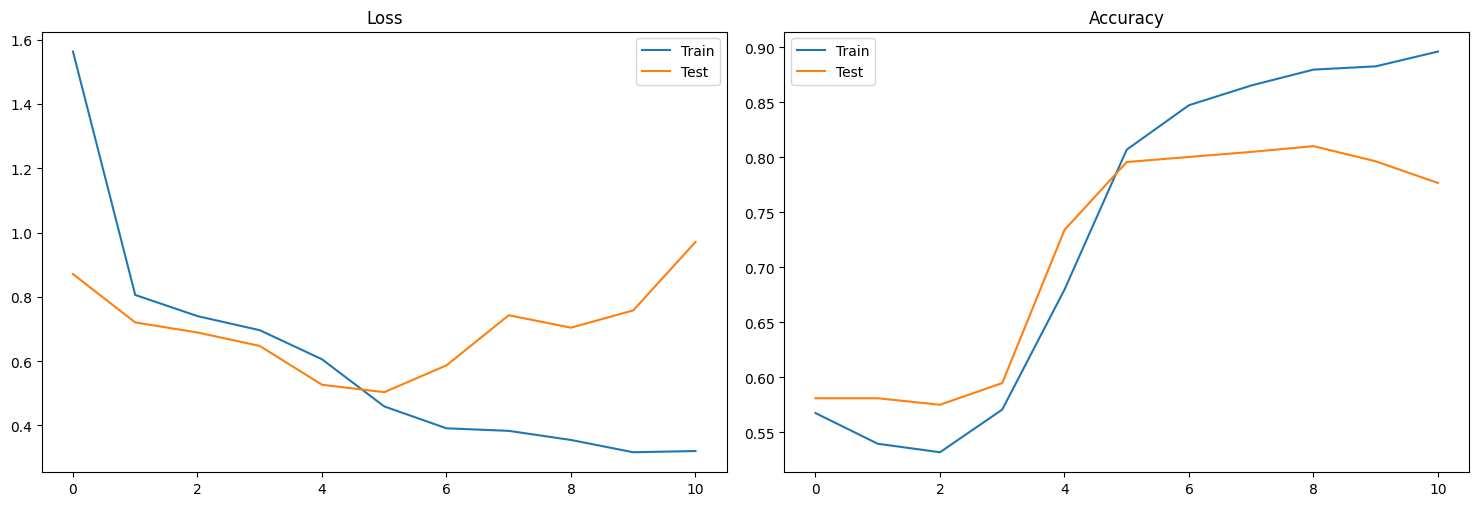

In [50]:
show_model_history(stacked_lstm_history)

## Step 5:  Conclusion
### Learnings and Takeaways
There appears to be both an art and a science to create neural networks.  Choosing the right architecture and hyperparameters significantly impact both the training time and prediction power of the model.

Additionally, the data used to train the model significantly affects the peformance.  Specifically, adjusting the maximum size of the vocabulary affected the validation accuracy of the models.  Although I did not include different variations of vocabulary size in this notebook, I noticed the impact of vocabulary size on validation accuracy during my development of the models.

### What did and did not help improve the performance of your models? 
The LSTM layers did not significantly improve the validation accuracy of the models.  This is likely because the Tweet text lengths were rather short, so the model did not suffer from the same level of gradient vanishing that we would see when processing larger sequences of text.

The bidirectional layers improved the validation accuracy of the models.  This is likely because context matters in text so understanding future and past tokens is important in understanding the entire Tweet.

### What improvements could you try in the future?
I noticed while building the various models that changing the vocabulary size (i.e., max_tokens) affected the models validation accuracy.  Specifically, a smaller vocabulary yielded higher accuracy.  My hypothesis is that the dataset is rather small, so many words were unique to a handful of Tweets.  Therefore, there was likely a less desirable signal-to-noise ratio in the training data when using larger vocabularies.  A future improvement would be to dig further into the ideal vocabulary size and either validate or disprove my hypothesis.

I also think it would be interesting to create a model using the keywords instead of the Tweet text.


## Submit to Competition
The remainder of this notebook (except for the references section) is the code needed to submit predictions to the Kaggle competition.

In [51]:
df_submit = df_submit[['id', 'text']]
df_submit['text'] = df_submit['text'].apply(clean_text)
df_submit.head()

,id,text
0,0,happened terrible car crash
1,2,heard earthquake different cities stay safe ev...
2,3,forest fire spot pond geese fleeing across str...
3,9,apocalypse lighting spokane wildfires
4,11,typhoon soudelor kills china taiwan


In [52]:
predictions = stacked_lstm.predict(df_submit['text'].values)

y_pred = (predictions > 0.5).astype(int)

unique_values, counts = np.unique(y_pred, return_counts=True)

print('Unique values:', unique_values)
print('Counts:', counts)

102/102 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Unique values: [0 1]
Counts: [2238 1025]


In [54]:
df = pd.DataFrame.from_records(y_pred.tolist(), columns=['target'])
submission = pd.DataFrame({'id': df_submit['id'], 'target': df['target']})
submission.head()

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1


In [ ]:
submission.to_csv('submission.csv', index=False)

### References
1. Addison Howard, devrishi, Phil Culliton, and Yufeng Guo. Natural Language Processing with Disaster Tweets. https://kaggle.com/competitions/nlp-getting-started, 2019. Kaggle.
2. https://www.nltk.org/api/nltk.html
3. https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer
4. https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
5. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
6. https://www.tensorflow.org/text/tutorials/text_classification_rnn
7. https://www.simplilearn.com/tutorials/deep-learning-tutorial/deep-learning-algorithm
8. https://medium.com/analytics-vidhya/rnn-vs-gru-vs-lstm-863b0b7b1573